In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import librosa, librosa.display
from scipy import signal
import scipy 
import os
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import lag_plot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import cm


## Example of data

In [2]:
a = pd.read_csv('state1/data210.txt', delimiter=r'\s+', header=None)


FileNotFoundError: [Errno 2] File b'state1/data210.txt' does not exist: b'state1/data210.txt'

In [217]:
a.head()

0         1         2         3         4
0  12.39570 -0.131686  0.706660 -0.691481  0.278448
1   2.32147 -0.560485  0.889149 -0.218212 -0.129904
2  -8.93433 -0.216303 -0.195309  0.776039 -0.587948
3  17.35840  0.624704 -0.766023  0.652192 -0.315564
4   8.74513  0.194614  0.026529 -0.558402  0.471487

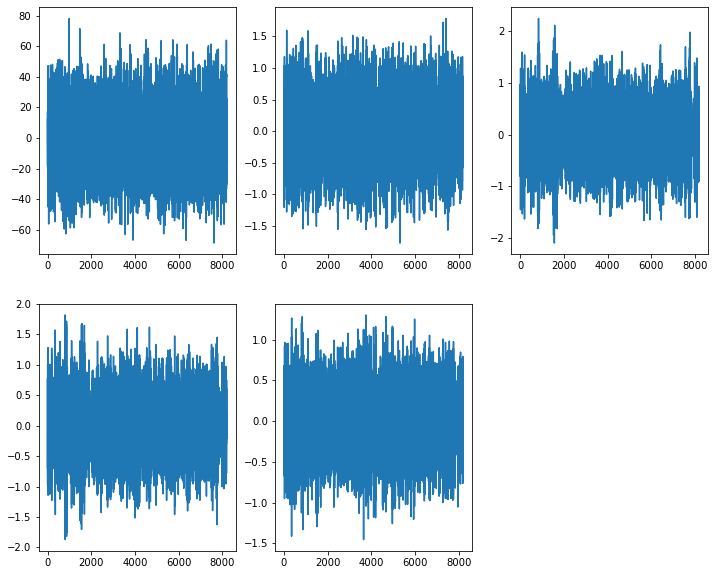

In [218]:
plt.figure(figsize=(12,10))
plt.subplot(2,3,1)
plt.plot(a[0])
plt.subplot(2,3,2)
plt.plot(a[1])
plt.subplot(2,3,3)
plt.plot(a[2])
plt.subplot(2,3,4)
plt.plot(a[3])
plt.subplot(2,3,5)
plt.plot(a[4])

## FRF

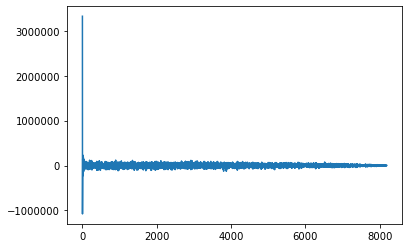

In [219]:
# Calculate Autocorrelation by numpy
x = a[0]
r = np.correlate(x, x, mode='full')[len(x)-1:]
plt.plot(r)

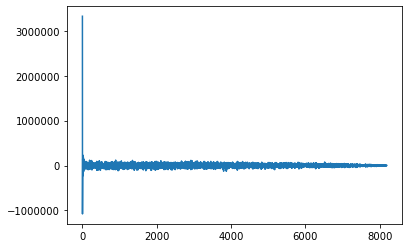

In [220]:
# Calculate Autocorrelation by librosa
r = librosa.autocorrelate(x, max_size=len(x))
plt.plot(r)

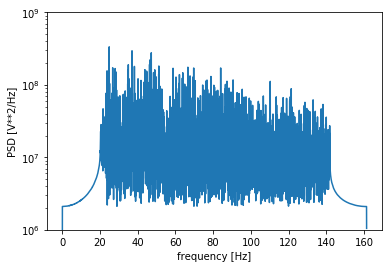

In [221]:
fs = 322.58
f, Pxx_den = signal.periodogram(r, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e6, 1e9])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [222]:
# Calculate Autocorrelation by numpy
x = a[0]
y = a[4]
r_xx = np.correlate(x, x, mode='full')[len(x)-1:]
_, Sxx = signal.periodogram(r_xx, fs)

r_yy = np.correlate(y, y, mode='full')[len(y)-1:]
_, Syy = signal.periodogram(r_yy, fs)

r_xy = np.correlate(x, y, mode='full')[len(x)-1:]
_, Sxy = signal.periodogram(r_xy, fs)

r_yx = np.correlate(y, x, mode='full')[len(x)-1:]
_, Syx = signal.periodogram(r_yx, fs)


(20, 150)

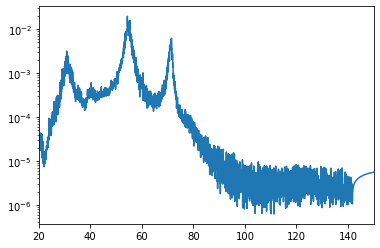

In [223]:
H1 = Syx / Sxx  # element-wise division
# H1 = np.divide(Syx, Sxx)
# H2 = Syy / Sxy
# H2 = np.divide(Syy, Sxy)
plt.semilogy(f, H1)
plt.xlim(20,150)


(20, 150)

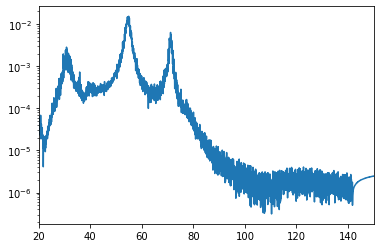

In [8]:
a = pd.read_csv('state#1/data211.txt', delimiter=r'\s+', header=None)
x = a[0]
y = a[4]
r_xx = np.correlate(x, x, mode='full')[len(x)-1:]
_, Sxx = signal.periodogram(r_xx, fs)

r_yx = np.correlate(y, x, mode='full')[len(x)-1:]
_, Syx = signal.periodogram(r_yx, fs)

H1_1 = Syx / Sxx  # element-wise division
plt.semilogy(f, H1_1)
plt.xlim(20,150)


(20, 150)

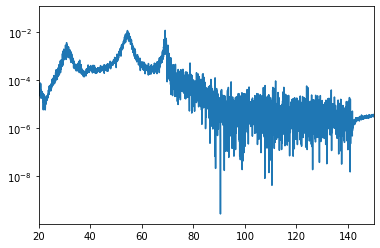

In [6]:
fs = 322.58
a = pd.read_csv('state#17/data230.txt', delimiter=r'\s+', header=None)
x = a[0]
y = a[4]
r_xx = np.correlate(x, x, mode='full')[len(x)-1:]
_, Sxx = signal.periodogram(r_xx, fs)

r_yx = np.correlate(y, x, mode='full')[len(x)-1:]
f, Syx = signal.periodogram(r_yx, fs)

H1_17 = Syx / Sxx  # element-wise division
plt.semilogy(f, H1_17)
plt.xlim(20,150)


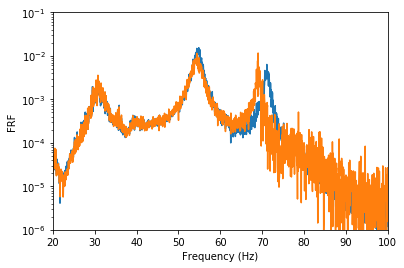

In [13]:
plt.semilogy(f, H1_1)
plt.semilogy(f, H1_17)
plt.xlim(20,100)
plt.ylim(1e-6,1e-1)
plt.xlabel('Frequency (Hz)');
plt.ylabel('FRF');

## STATISTICS

In [72]:
i_state = 16
i_serie = 1
mean_value = np.zeros((17,9))

folder = 'state#'+str(i_state)
listfile= os.listdir(folder)
filename = listfile[i_serie]
sep =  os.path.sep
getfile = folder + sep + filename
a = pd.read_csv(getfile, delimiter=r'\s+', header=None)
mean_value[i_state, i_serie] = np.mean(a[4])


In [73]:
state = np.array(range(1,18))
serie = np.array(range(1,10))

mean_value = np.zeros((17,9))
std_value = np.zeros((17,9))
skew_value = np.zeros((17,9))
kurtosis_value = np.zeros((17,9))

for i_state in range(17):
    folder = 'state#'+str(i_state+1)
    listfile= os.listdir(folder)
    for i_serie in range(9):                
        filename = listfile[i_serie]
        sep =  os.path.sep
        getfile = folder + sep + filename
        a = pd.read_csv(getfile, delimiter=r'\s+', header=None)
        mean_value[i_state, i_serie] = np.mean(a[4])
        std_value[i_state, i_serie] = np.std(a[4])
        skew_value[i_state, i_serie] = scipy.stats.skew(a[4])
        kurtosis_value[i_state, i_serie] = scipy.stats.kurtosis(a[4])

In [74]:
np.shape(mean_value)

(17, 9)

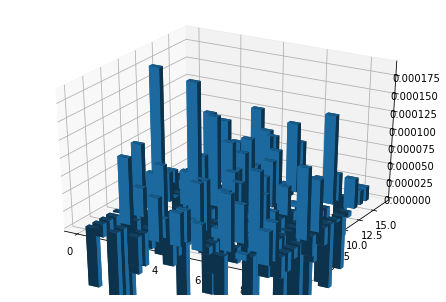

In [75]:
data = mean_value

fig = plt.figure()
ax = Axes3D(fig)
ly, lx = np.shape(data)
xpos = np.arange(0,lx,1)    # Set up a mesh of positions
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten()   # Convert positions to 1D array
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()
ax.bar3d(xpos,ypos,zpos, dx, dy, dz)

plt.show()

In [76]:
def plot_3D(data):
    fig = plt.figure()
    ax = Axes3D(fig)
    ly, lx = np.shape(data)
    xpos = np.arange(0,lx,1)
    ypos = np.arange(0,ly,1)
    xpos, ypos = np.meshgrid(xpos, ypos)
    xpos = xpos.flatten()   
    ypos = ypos.flatten()
    zpos = np.zeros(lx*ly)
    dx = 0.5 * np.ones_like(zpos)
    dy = 0.5 * np.ones_like(zpos)
    dz = data.flatten()
    ax.bar3d(xpos,ypos,zpos, dx, dy, dz)

    plt.show()

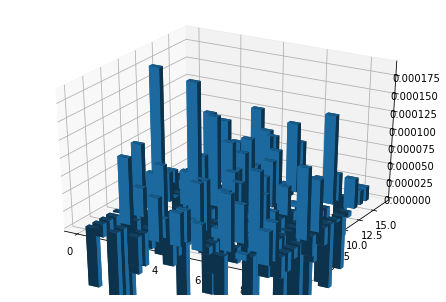

In [77]:
plot_3D(mean_value)

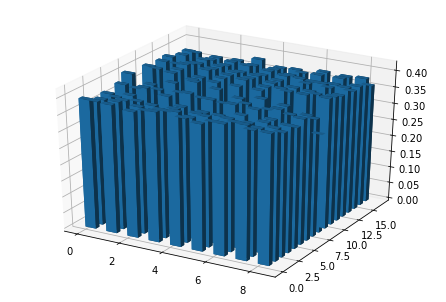

In [78]:
plot_3D(std_value)

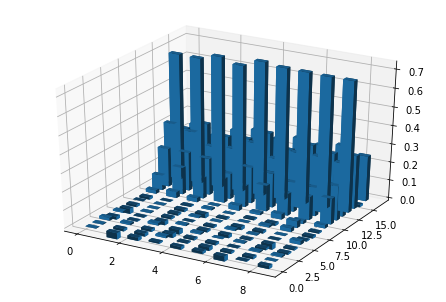

In [81]:
plot_3D(-skew_value)

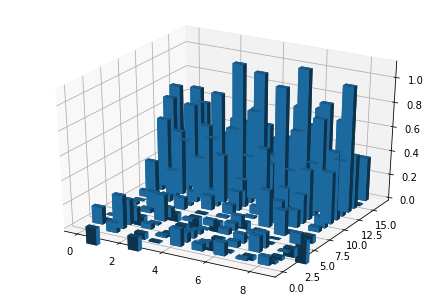

In [76]:
plot_3D(kurtosis_value)

In [77]:
np.shape(skew_value)

(17, 9)

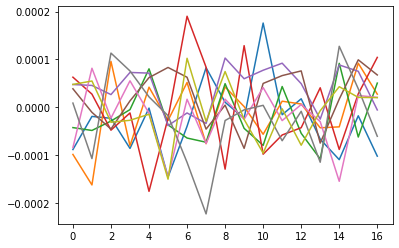

In [78]:
for i in range(9):
    plt.plot(data[:,i])


In [79]:
# Autocorrelation
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf

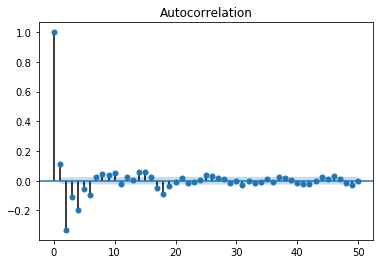

In [80]:
plot_acf(x, lags=50)
plt.show()

In [81]:
statsmodels.tsa.stattools.acf(x)

array([ 1.00000000e+00,  1.15651517e-01, -3.31354165e-01, -1.10721665e-01,
       -1.94690684e-01, -5.32716438e-02, -9.51519933e-02,  2.32019387e-02,
        4.37480495e-02,  3.94511757e-02,  5.01322633e-02, -2.45842107e-02,
        2.70850678e-02,  6.80107160e-03,  5.69846556e-02,  5.77946050e-02,
        2.22306488e-02, -4.92883418e-02, -8.79362117e-02, -3.88670410e-02,
       -1.11413295e-02,  1.75883909e-02, -1.41660489e-02, -6.86385019e-03,
        5.73425349e-03,  3.95988787e-02,  3.46058760e-02,  1.73242921e-02,
        1.00506576e-02, -1.64409197e-02, -6.13656284e-04, -2.92548580e-02,
       -5.14375335e-03, -1.47803680e-02, -9.98334545e-03,  1.11894129e-02,
       -9.65924550e-03,  2.72881067e-02,  1.69953360e-02,  7.60313539e-03,
       -1.28858987e-02])

In [82]:
list_state = [1, 3, 7, 14, 17]
signal_concat = []

for i_state in list_state:
    folder = 'state#'+str(i_state)
    listfile= os.listdir(folder)
    for i_serie in range(1):                
        filename = listfile[i_serie]
        sep =  os.path.sep
        getfile = folder + sep + filename
        a = pd.read_csv(getfile, delimiter=r'\s+', header=None)
        signal_concat += a[1].to_list()


In [83]:
np.shape(signal_concat)

(40960,)

In [84]:
len(signal_concat)/5    

8192.0

In [85]:
fs = 322.58
t = np.array(range(len(signal_concat)))/fs

(-2, 2)

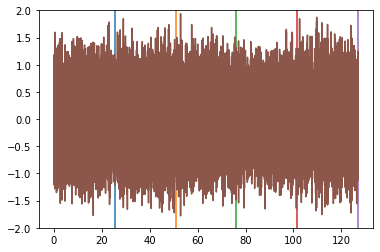

In [86]:
T=len(signal_concat)/5 / fs    
yy=[-10,10]
for i in range(5):
    xx=np.array([T, T])*(i+1)
    plt.plot(xx,yy)

plt.plot(t, signal_concat)
plt.ylim(-2,2)


In [87]:
list_state = [1, 3, 14, 17]

In [91]:
def get_data(i_state, i_serie):
    folder = 'state#'+str(i_state)
    listfile= os.listdir(folder)
    filename = listfile[i_serie]
    sep =  os.path.sep
    getfile = folder + sep + filename
    a = pd.read_csv(getfile, delimiter=r'\s+', header=None)

    return a

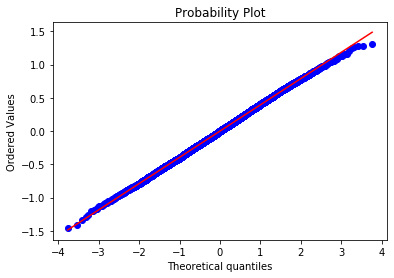

In [92]:
a = get_data(1,0)
x = a[4]
res = scipy.stats.probplot(x, plot=plt)


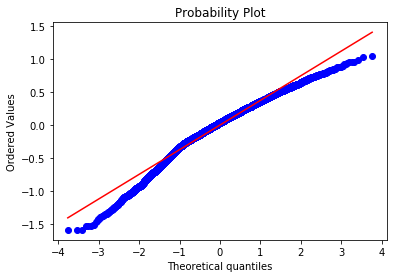

In [93]:
a = get_data(14,1)
x = a[4]
res = scipy.stats.probplot(x, plot=plt)

## Autoregression

In [94]:
type(x)

pandas.core.series.Series

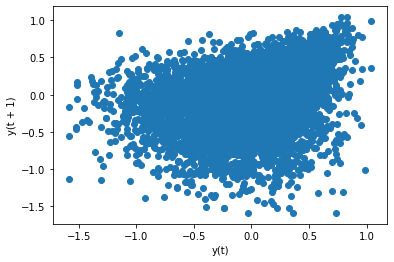

In [95]:
lag_plot(x)

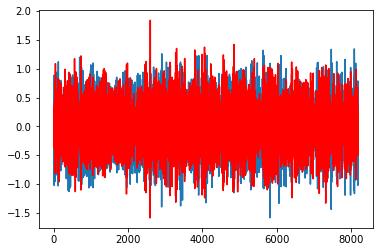

In [98]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

x = get_data(1,1)[4].to_list()
y = get_data(1,3)[4].to_list()
model = AR(x)
p = 10
model_fit = model.fit(p, ic = 'aic')

# make predictions
predictions = model_fit.predict(start=p+1, end=len(y), dynamic=False)

plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

In [99]:
model_fit.aic

-6.047094107161974

In [105]:
list_p = np.arange(0,61,5)
list_p[0]=1

In [106]:
list_aic = []

for p in list_p:
    model = AR(x)
    model_fit = model.fit(p, ic = 'aic')
    list_aic.append(model_fit.aic)
    
   

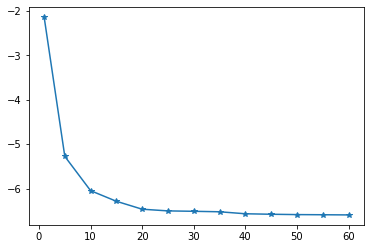

In [107]:
plt.plot(list_p, list_aic,'-*')

In [108]:
x = get_data(i_state=1, i_serie=1)[4].to_list()
y = get_data(i_state=1, i_serie=3)[4].to_list()


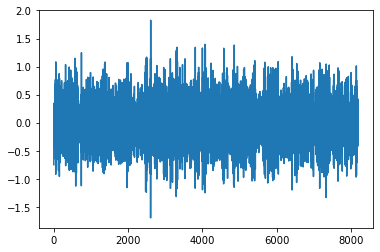

In [109]:
plt.plot(x)

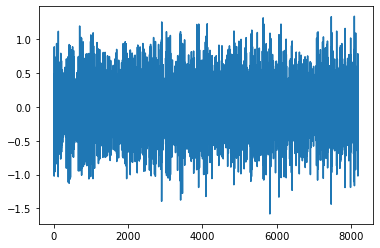

In [110]:
plt.plot(y)

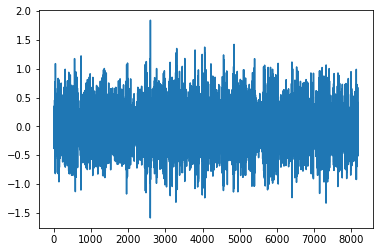

In [111]:
plt.plot(predictions)

In [112]:
list_rmse = []
y = np.array(y)
for p in list_p:
    model = AR(x)
    model_fit = model.fit(p, ic = 'aic')
    predictions = model_fit.predict(start=p+1, end=len(y), dynamic=False)
    list_rmse.append(rmse(y[p:], predictions))
    

In [113]:
list_rmse

[0.42958752485554896,
 0.5548851367508568,
 0.5574811172696545,
 0.5580250060936686,
 0.5582401663874184,
 0.558415243298353,
 0.5586155655613712,
 0.5587441654539798,
 0.5588950579587301,
 0.5590193808604407,
 0.5589980349749614,
 0.5588104848572681,
 0.5586188879407277]

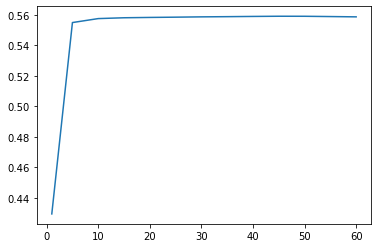

In [114]:
plt.plot(list_p, list_rmse)

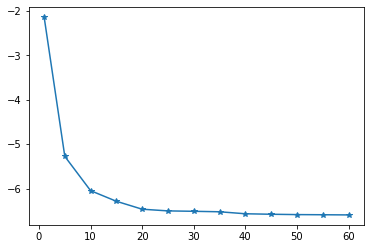

In [115]:
plt.plot(list_p, list_aic,'-*')

In [117]:
def get_data(i_state, i_serie):
    folder = 'state#'+str(i_state)
    listfile= os.listdir(folder)
    filename = listfile[i_serie]
    sep =  os.path.sep
    getfile = folder + sep + filename
    a = pd.read_csv(getfile, delimiter=r'\s+', header=None)

    return a

In [118]:
list_p = np.arange(0,61,5)
list_p[0] = 1

In [119]:
x = get_data(1,1)[4].to_list()
y = get_data(1,3)[4].to_list()

In [120]:
list_rmse = []

for p in list_p:
    model = AR(x)
    model_fit = model.fit(p, ic = 'aic')
    pred = model_fit.predict(start=p+1, end=len(x), dynamic=False)
    list_rmse.append(rmse(x[p:], pred))
    

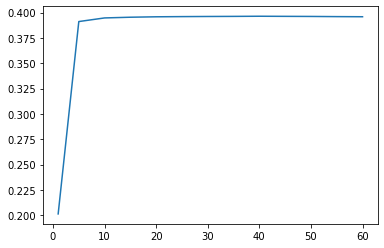

In [121]:
plt.plot(list_p, list_rmse)

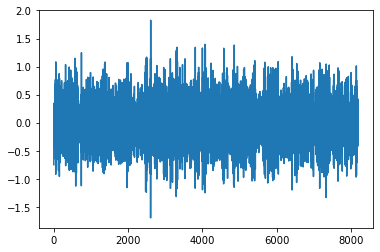

In [122]:
plt.plot(x)

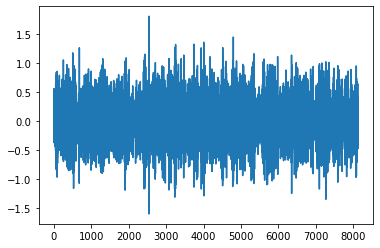

In [123]:
plt.plot(pred)

In [124]:
coef = model_fit.params

In [125]:
order = len(coef)

In [126]:
pred = list(y[0:order])

In [127]:
coef = model_fit.params

In [128]:
pred = list(y[0:order])

In [129]:
np.multiply(coef[1:],pred[-60:-1])

array([-2.25162495e-02, -9.88662864e-01,  1.19558927e+00, -9.51607299e-01,
       -1.57107230e-01,  6.50229560e-01,  5.53361461e-01, -2.34413880e+00,
        5.76846249e-01,  2.44583519e+00, -1.89484010e+00,  1.10482758e+00,
        7.83646990e-01, -1.82926194e+00,  5.71724537e-04,  4.37242003e-01,
        2.29437616e-01, -3.84440240e-02, -4.03425021e-01, -1.74686372e-02,
        5.59008470e-01, -7.57336144e-03, -1.62657124e-01, -1.96199868e-01,
       -7.73495390e-02, -5.04216920e-02, -9.93547076e-03,  3.47300588e-01,
       -1.21925361e-01,  1.92634465e-01,  8.97025365e-02, -3.51512545e-01,
       -1.12232186e-03,  1.89705321e-01, -3.76661226e-02, -5.69056825e-02,
       -1.31716935e-01, -1.00806729e-01,  3.08768897e-01, -9.73423572e-02,
       -7.36920230e-02,  4.29931452e-02,  2.47116561e-02, -1.44901951e-02,
       -8.01467027e-04,  4.93787702e-02, -1.33315832e-01,  1.90649471e-01,
       -7.04901103e-02,  1.88046445e-02,  9.21356521e-03, -5.27735683e-02,
        6.78859779e-02, -

In [132]:
pred = list(y[0:order])
for t in range(order, len(y)):
    yhat = coef[0]+ np.sum(np.multiply(coef[1:],pred[-order:-1]))
    pred += yhat
    
    

In [134]:
list_rmse = []

for p in list_p:
    model = AR(x)
    model_fit = model.fit(p, ic = 'aic')
    pred = model_fit.predict(start=p+1, end=len(x), dynamic=False)
    list_rmse.append(rmse(x[p:], pred))

In [135]:
train, test = x, y
# train autoregression
p = 5
model = AR(train)
model_fit = model.fit(p)
coef = model_fit.params

In [136]:
history = list(test[:p])
predictions = list(test[:p])

for t in range(p,len(test)):
    lag = history[-p:]
    yhat = coef[0]    
    for d in range(p):
        yhat += coef[d+1] * lag[p-d-1]    

    history.append(test[t])
    predictions.append(yhat)
    
error = rmse(test, predictions)
error

0.07331652749714727

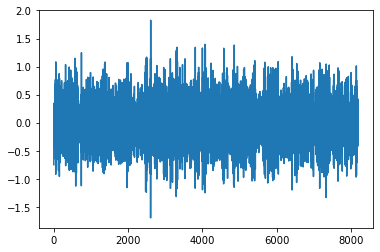

In [137]:
plt.plot(x)

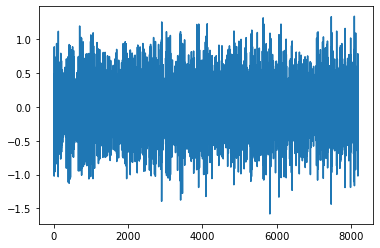

In [138]:
plt.plot(y)

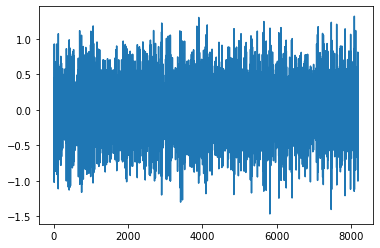

In [139]:
plt.plot(predictions)

In [140]:
def cal_rmse(coef, p, test):
    predictions = []
    for t in range(p,len(test)):
        yhat = coef[0]    
        for d in range(p):
            yhat += coef[d+1] * test[t-1-d]    

        predictions.append(yhat)

    return rmse(test[p:], predictions)

In [141]:
list_p = np.arange(0,61,1)
list_p[0] = 1

x = get_data(1,1)[4].to_list()
y = get_data(1,3)[4].to_list()

list_rmse = []
for p in list_p:
    model = AR(x)
    model_fit = model.fit(p)   
    list_rmse.append(cal_rmse(model_fit.params, p, test))


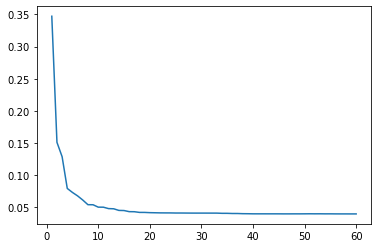

In [142]:
plt.plot(list_p, list_rmse)

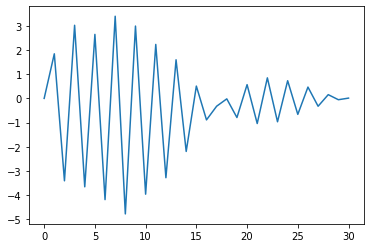

In [144]:
model = AR(x)
model_fit = model.fit(30)   

plt.plot(model_fit.params)

In [145]:
x = get_data(1,1)[4].to_list()
p=60
M = np.array(x[:len(x)-p])
M = M.reshape(-1,1)


In [146]:
np.shape(M)

(8132, 1)

In [147]:
for i in range(1,p):
    m = np.array(x[i:i+len(x)-p]).reshape(-1,1)
    M = np.concatenate((M, m), axis = 1)

In [148]:
np.shape(M)

(8132, 60)

In [149]:
u, s, vh = np.linalg.svd(M, full_matrices=True)

In [150]:
len(s)

60

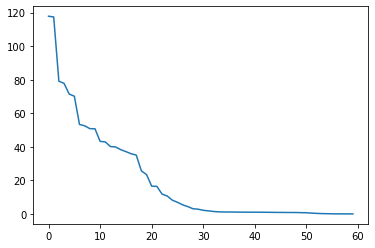

In [151]:
plt.plot(s)

In [152]:
x = get_data(1,1)[4].to_list()
model = AR(x)
AR5 = model.fit(5)   
AR30 = model.fit(30)   


In [153]:
def predict(model_fit, p, test):
    coef = model_fit.params
    predictions = test[:p]
    for t in range(p,len(test)):
        yhat = coef[0]    
        for d in range(p):
            yhat += coef[d+1] * test[t-1-d]    

        predictions.append(yhat)
        
    return predictions

In [154]:
x5 = predict(AR5, 5, x)
x30 = predict(AR30, 30, x)

In [155]:
len(x5)

8192

In [156]:
len(x30)

8192

In [157]:
r5 = np.array(x) - np.array(x5)
r30 = np.array(x) - np.array(x30)

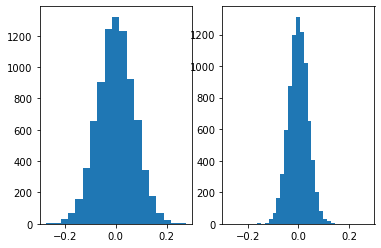

In [158]:
plt.subplot(1,2,1)
plt.hist(r5, bins = 20);
plt.xlim(-0.3,0.3);
plt.subplot(1,2,2)
plt.hist(r30, bins = 20);
plt.xlim(-0.3,0.3);

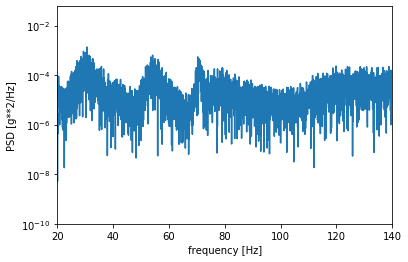

In [159]:
fs = 322.58
f, Pxx_den = signal.periodogram(r5, fs)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [g**2/Hz]')
plt.xlim(20,140)
plt.ylim(1e-10)
plt.show()

In [25]:
fs = 322.58
f, Pxx_den = signal.periodogram(r30, fs)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [g**2/Hz]')
plt.xlim(20,140)
plt.ylim(1e-10)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'periodogram'

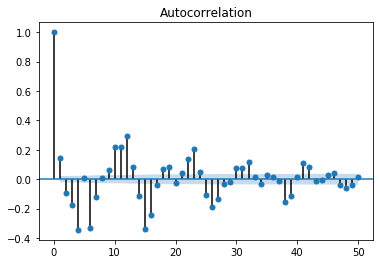

In [161]:
plot_acf(r5, lags=50)
plt.show()

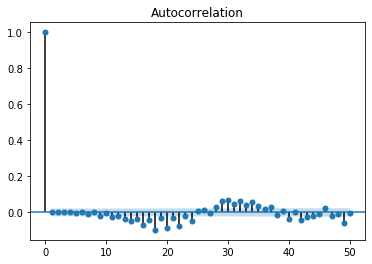

In [162]:
plot_acf(r30, lags=50)
plt.show()

In [164]:
e_res = pd.DataFrame({'r5':r5, 'r30':r30})

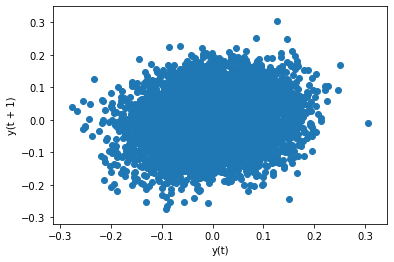

In [165]:
lag_plot(e_res['r5'])

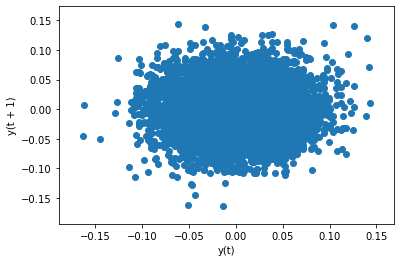

In [166]:
lag_plot(e_res['r30'])

In [18]:
def get_data(i_state, i_serie):
    folder = 'state#'+str(i_state)
    listfile= os.listdir(folder)
    filename = listfile[i_serie]
    sep =  os.path.sep
    getfile = folder + sep + filename
    a = pd.read_csv(getfile, delimiter=r'\s+', header=None)

    return a

In [168]:
N_serie=9

In [25]:
def AR_model(x, p):
    model = AR(x)
    return model.fit(p)   

def coef_model(x, p):
    coef = AR(x).fit(p).params
    return coef

In [170]:
x = get_data(1,1)[4].to_list()

AR5 = AR_model(x,5)   
AR30 = AR_model(x,30)   


In [171]:
def predict(model_fit, p, test):
    coef = model_fit.params
    predictions = test[:p]
    for t in range(p,len(test)):
        yhat = coef[0]    
        for d in range(p):
            yhat += coef[d+1] * test[t-1-d]    

        predictions.append(yhat)
        
    return predictions

In [172]:
x5 = predict(AR5, 5, x)
x30 = predict(AR30, 30, x)

In [173]:
r5 = np.array(x) - np.array(x5)
r30 = np.array(x) - np.array(x30)

In [174]:
def residual(x, p):
    AR_p = AR_model(x, p) 
    xp = predict(AR_p, p, x)
    rp = np.array(x) - np.array(xp)
    return rp

In [175]:
p = 30
x = get_data(1,0)[4].to_list()
coef = coef_model(x, p)
coef = np.expand_dims(coef, axis=0)
M = coef

for i in range(1,9):
    x = get_data(1,i)[4].to_list()
    coef = coef_model(x, p)
    coef = np.expand_dims(coef, axis=0)
    M = np.concatenate((M,coef),axis=0)
        

In [176]:
pca = PCA(n_components=9)
pca.fit(M)
pc_component = pca.explained_variance_

In [177]:
M.shape

(9, 31)

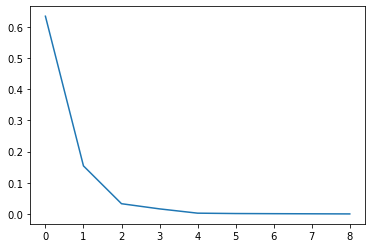

In [178]:
plt.plot(pc_component)

In [180]:
A = np.array([[90, 60, 90], [90, 90, 30], [60, 60, 60], [60, 60, 90], [30, 30, 30]])
pca = PCA(3)
pca.fit(A)
print(pca.components_)
print(pca.explained_variance_)


[[-0.65580225 -0.4291978  -0.62105769]
 [ 0.3859988   0.51636642 -0.7644414 ]
 [ 0.6487899  -0.74104991 -0.17296443]]
[1137.5874413   786.38798335   56.02457535]


In [181]:
def cal_PCA(p=30,i_state=1):
    x = get_data(i_state,0)[4].to_list()
    coef = coef_model(x, p)
    coef = np.expand_dims(coef, axis=0)
    M = coef

    for i in range(1,9):
        x = get_data(1,i)[4].to_list()
        coef = coef_model(x, p)
        coef = np.expand_dims(coef, axis=0)
        M = np.concatenate((M,coef),axis=0)

    pca = PCA(n_components=9)
    pca.fit(M)
    pc_component = pca.explained_variance_

    return pc_component
    

In [182]:
cal_PCA(30,i_state=1)

array([6.34362836e-01, 1.54127661e-01, 3.27368405e-02, 1.61530817e-02,
       2.40558964e-03, 1.22544266e-03, 7.65173766e-04, 3.78785862e-04,
       1.59021226e-30])

In [183]:
pca1 = []
for i_state in range(1,18):
    v1 = cal_PCA(30,i_state)[0]
    pca1.append(v1)

<BarContainer object of 17 artists>

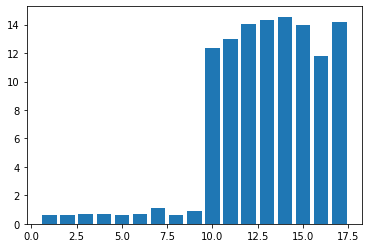

In [184]:
list_state = np.arange(1,18)
plt.bar(list_state, pca1)

In [185]:
r25 = []
r45 = []
for i_state in range(1,18):
    x = get_data(i_state,0).to_numpy().T
    cov_mat = np.cov(x)
    r25.append(cov_mat[1,4])
    r45.append(cov_mat[3,4])
    
    

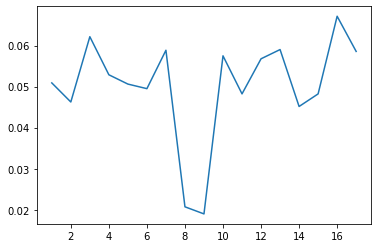

In [186]:
plt.plot(list_state, r25)

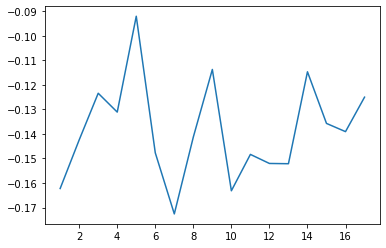

In [187]:
plt.plot(list_state, r45)

## STFT  - short time Fourier transformation

In [45]:
import librosa
import librosa.display
import pylab


In [46]:
x = get_data(1,0)[4].to_numpy()

In [47]:
len(x)/fs

25.39525079050158

In [48]:
fs = 322.58
n_fft = 150
hop_length = 512

stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)


In [49]:
type(stft_magnitude)

numpy.ndarray

In [50]:
stft_magnitude.shape

(76, 17)

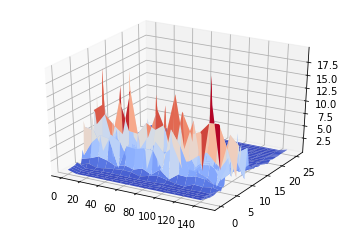

In [51]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Y = np.linspace(0,25.4,76)
X = np.linspace(0,150,17)
X, Y = np.meshgrid(X, Y)
Z = stft_magnitude
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)


In [52]:
Z.shape

(76, 17)

In [53]:
X = np.arange(-5, 5, 0.25)

In [54]:
Y = np.arange(-5, 5, 0.5)

In [55]:
f = np.linspace(0,150,17)

In [56]:
import plotly.graph_objects as go

In [57]:
sh_0, sh_1 = Z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y)])
fig.show()                                                                                                                                                                                                                                                                                                                                                

In [58]:
np.shape(stft)

(76, 17)

In [59]:
signal = get_data(1,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
stft_magnitude, stft_phase = librosa.magphase(stft)


In [60]:
data = stft_magnitude.T
sh_0, sh_1 = data.shape
x = np.linspace(0,150,sh_1)
y = np.linspace(0,25.4,sh_0)
fig = go.Figure(data=[go.Surface(z=data, x=x, y=y)])
fig.show()

In [61]:
data = stft_magnitude.T
sh_0, sh_1 = data.shape
x = np.linspace(0,150,sh_1)
y = np.linspace(0,25.4,sh_0)
fig = go.Figure(data=[go.Contour(z=data, x=x, y=y)])
fig.show()

In [62]:
signal = get_data(14,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
stft_magnitude, stft_phase = librosa.magphase(stft)

data = stft_magnitude.T
sh_0, sh_1 = data.shape
x = np.linspace(0,150,sh_1)
y = np.linspace(0,25.4,sh_0)
fig = go.Figure(data=[go.Contour(z=data, x=x, y=y)])
fig.show()

In [63]:
np.concatenate((data,data),axis=0).shape

(66, 257)

In [70]:
signal = get_data(1,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
stft_magnitude, stft_phase = librosa.magphase(stft)
data1 = stft_magnitude.T

signal = get_data(3,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
stft_magnitude, stft_phase = librosa.magphase(stft)
data2 = stft_magnitude.T

signal = get_data(14,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
stft_magnitude, stft_phase = librosa.magphase(stft)
data3 = stft_magnitude.T

data3 = np.concatenate((data1,data2,data3),axis=0)
sh_0, sh_1 = data3.shape
x = np.linspace(0,150,sh_1)
y = np.linspace(0,2*25.4,sh_0)
fig = go.Figure(data=[go.Contour(z=data3, x=x, y=y)])
fig.show()

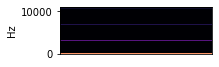

In [65]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')

C:\Users\Admin\Anaconda3\lib\site-packages\librosa\display.py:725: UserWarning:

Trying to display complex-valued input. Showing magnitude instead.



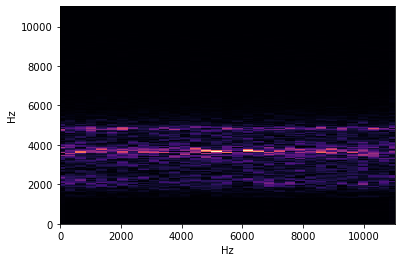

In [66]:
signal = get_data(1,0)[4].to_numpy()
stft = librosa.stft(signal, n_fft=512, hop_length=256) # by default win_length = n_fft
librosa.display.specshow(stft, x_axis='linear', y_axis='linear')

## X-bar control

In [26]:
def predict(model_fit, p, test):
    coef = model_fit.params
    predictions = test[:p]
    for t in range(p,len(test)):
        yhat = coef[0]    
        for d in range(p):
            yhat += coef[d+1] * test[t-1-d]    

        predictions.append(yhat)
        
    return predictions

In [27]:
def residual(x, p):
    AR_p = AR_model(x, p) 
    xp = predict(AR_p, p, x)
    rp = np.array(x) - np.array(xp)
    return rp

In [28]:
x = get_data(1,0)[4].to_list()
r = residual(x, 30)

(0, 10)

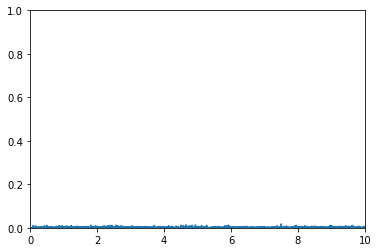

In [29]:
t = np.linspace(0,25, len(r))
plt.plot(t,r**2)
plt.ylim(0,1)
plt.xlim(0,10)

In [30]:
x = get_data(1,0)[4].to_list()
r = residual(x, 30)

In [31]:
mu_0 = np.mean(r)
std_0 = np.std(r)
print(mu_0, std_0)

4.347650711666873e-17 0.03796652849799775


In [32]:
r_norm = (r - mu_0)/ std_0

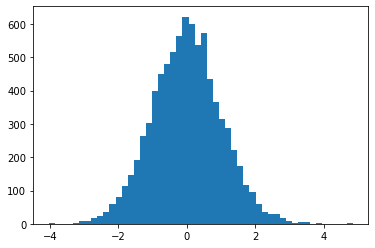

In [33]:
plt.hist(r_norm, bins = 50);

In [34]:
n_gr = 4
Np = len(r_norm) // n_gr
r_gr = [np.mean(r_norm[i*n_gr:(i+1)*n_gr]) for i in range(Np) ]

In [35]:
x = get_data(1,0)[4].to_list()
p = 5
r = residual(x, p)
mu_0 = np.mean(r)
std_0 = np.std(r)

In [36]:
def r_Xbar(x, p, n_gr, mu_0, std_0):
    r = residual(x, p)
    r_norm = (r - mu_0)/ std_0
    Np = len(r) // n_gr
    r_gr = [np.mean(r_norm[i*n_gr:(i+1)*n_gr]) for i in range(Np) ]
    
    return r_gr


(-2.5, 2.5)

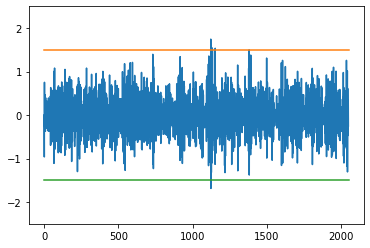

In [43]:
x = get_data(3,5)[4].to_list()

n_gr=4
r_gr = r_Xbar(x, p, n_gr, mu_0, std_0)
UCL = 3/np.sqrt(n_gr) 
LCL = -3/np.sqrt(n_gr)

plt.plot(r_gr)
plt.plot([0, len(r_gr)], [UCL, UCL])
plt.plot([0, len(r_gr)], [LCL, LCL])
plt.ylim(-2.5,2.5)

(-2.5, 2.5)

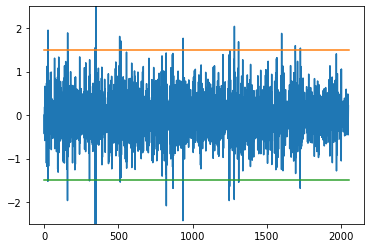

In [44]:
x = get_data(10,5)[4].to_list()

n_gr=4
r_gr = r_Xbar(x, p, n_gr, mu_0, std_0)
UCL = 3/np.sqrt(n_gr) 
LCL = -3/np.sqrt(n_gr)

plt.plot(r_gr)
plt.plot([0, len(r_gr)], [UCL, UCL])
plt.plot([0, len(r_gr)], [LCL, LCL])
plt.ylim(-2.5,2.5)


In [224]:
p = 30
n_gr = 4

x = get_data(1,0)[4].to_list()
r = residual(x, p)
mu_0 = np.mean(r)
std_0 = np.std(r)

UCL = 3/np.sqrt(n_gr) 

out = []
for i_state in list_state: 
    x = get_data(i_state,5)[4].to_list()
    r_gr = np.array(r_Xbar(x, p, n_gr, mu_0, std_0))
    
    out.append(len(r_gr[np.abs(r_gr) > UCL]))

<BarContainer object of 17 artists>

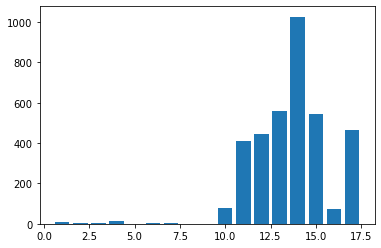

In [225]:
plt.bar(list_state, out)

In [226]:
type(r_gr)

numpy.ndarray

## CLUSTERING

In [228]:
def coef_model(x, p):
    coef = AR(x).fit(p).params
    return coef

In [229]:
p = 30

r_cluster = np.zeros((17,9,31))
y_cluster = np.zeros((17,9,))

for i_state in list_state: 
    for i_serie in range(9): 
        x = get_data(i_state, i_serie)[4].to_list()
        coef = coef_model(x, p)
        r_cluster[i_state-1, i_serie, :] = coef
        y_cluster[i_state-1, i_serie] = int(i_state>9)
        
x_cluster = r_cluster.reshape(-1,31)    
y_cluster = y_cluster.reshape(-1).astype(int)

In [230]:
# Kmean clustering

kmeans = KMeans(n_clusters=2)
kmeans.fit(x_cluster)
y_hat = kmeans.fit_predict(x_cluster)


In [231]:
y_hat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [405]:
y_cluster

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [408]:
### Hierarchical clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [410]:
hc = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x_cluster)

In [411]:
y_hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

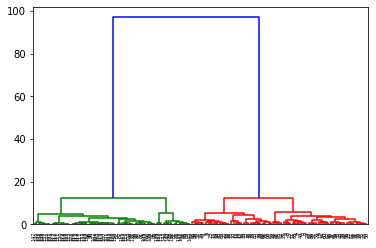

In [412]:
# The dendrogram plots out each cluster and the distance. 
# We can use the dendrogram to find the clusters for any number we chose
dendrogram = sch.dendrogram(sch.linkage(x_cluster, method='ward'))

ModuleNotFoundError: No module named 'torch'

##  Mahalanobis Distance

In [2]:
def get_data(i_state, i_serie):
    folder = 'state#'+str(i_state)
    listfile= os.listdir(folder)
    filename = listfile[i_serie]
    sep =  os.path.sep
    getfile = folder + sep + filename
    a = pd.read_csv(getfile, delimiter=r'\s+', header=None)

    return a

In [6]:
def coef_model(x, p):
    coef = AR(x).fit(p).params
    return coef

In [25]:
p = 30
M = np.zeros((36,p+1))

i = 0
for i_state in range(1,10):
    for i_serie in range(4):
        x = get_data(i_state,i_serie)[4].to_list()
        coef = coef_model(x, p)
        M[i,:] = coef
        i += 1
        
M = np.array(M).T        

In [26]:
cov_maha = np.cov(M)
mean_maha = np.mean(M, axis = 1)
Miv = np.linalg.inv(cov_maha)
    

In [27]:
maha = []
for i_state in range(1,18):
    x = get_data(i_state,0)[4].to_list()
    coef = coef_model(x, p)
    maha.append(scipy.spatial.distance.mahalanobis(coef, mean_maha, Miv))


In [28]:
list_state=np.array(range(1,18))

<BarContainer object of 17 artists>

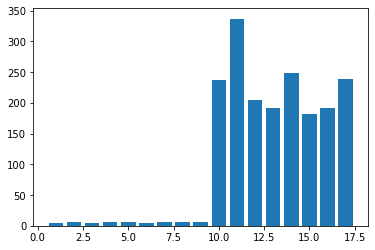

In [29]:
plt.bar(list_state, maha)

##  Singular Value Decomposition

In [41]:
def get_FRF(a, fs):
    x = a[0]
    y = a[4]
    r_xx = np.correlate(x, x, mode='full')[len(x)-1:]
    f, Sxx = signal.periodogram(r_xx, fs)

    r_yx = np.correlate(y, x, mode='full')[len(x)-1:]
    _, Syx = signal.periodogram(r_yx, fs)

    H1 = Syx / Sxx  # element-wise division
    return H1[:3088]

(20, 150)

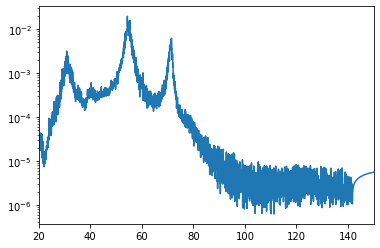

In [39]:
H1 = Syx / Sxx  # element-wise division
plt.semilogy(f, H1)
plt.xlim(20,150)


In [36]:
type(H1)

numpy.ndarray

In [37]:
H1.shape

(4097,)

In [45]:
fs = 322.58
M = np.zeros((3088,18))
i = 0
for i_state in range(1,10):
    for i_serie in range(2):
        a = get_data(i_state, i_serie)
        M[:,i] = get_FRF(a, fs)
        i += 1

In [46]:
u, s, vh = np.linalg.svd(M, full_matrices=True)

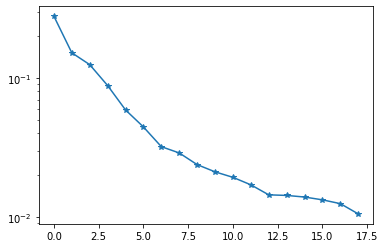

In [51]:
plt.semilogy(s,'-*')

In [52]:
a = get_data(14, 0)
addFRF = get_FRF(a, fs)

In [53]:
addFRF.shape

(3088,)

In [58]:
M2 = np.concatenate((M, np.expand_dims(addFRF, axis=1)),axis=1)

In [59]:
M2.shape

(3088, 19)

In [60]:
u2, s2, vh2 = np.linalg.svd(M2, full_matrices=True)

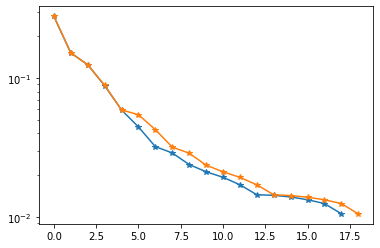

In [61]:
plt.semilogy(s,'-*',s2,'-*')